In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import time

import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import YearLocator, MonthLocator

import sklearn.mixture as mix

import missingno as msno
from tqdm import tqdm

In [3]:
strategy = os.getcwd()
print("change working directory to parent")
os.chdir('.')
print(os.getcwd())

strategy_dir = os.path.join(os.getcwd(), 'strategy_finance')

change working directory to parent
e:\NYU\Capstone\Code\regime_model


In [4]:
from utils.index_data import index_data
import pandas_datareader.data as web

In [5]:
data_setting = {
'start' : '1992-01-01',
'end'   : '2021-06-30',
'rebal_period':'1M'
}

list_index_data = ['msci_world', 'msci_emerging', 'bb_world_agg', 'bb_corp_hy', 'us_short_treasury']


data = index_data(**data_setting)
df = data.index_data_loading()
df = df[list_index_data]
df = df.fillna(0)
df

,msci_world,msci_emerging,bb_world_agg,bb_corp_hy,us_short_treasury
1992-01-31,0.000000,0.000000,-0.002171,0.035225,-0.000984
1992-02-29,-0.020678,0.103012,-0.013095,0.024673,0.003087
1992-03-31,-0.017357,0.054748,0.003074,0.012399,-0.000196
1992-04-30,-0.066034,0.029763,0.003851,0.003798,0.009191
1992-05-31,0.027579,-0.009451,0.006528,0.014110,0.009302
...,...,...,...,...,...
2021-02-28,0.002914,0.053679,-0.006128,0.004106,0.000204
2021-03-31,0.031810,0.001014,-0.016604,0.005491,-0.000255
2021-04-30,0.020293,-0.019986,-0.007515,0.000708,-0.000649
2021-05-31,0.038195,0.002734,0.005114,0.010157,0.000970


In [6]:
data = index_data(**data_setting)
world_index = data.index_cum_data_loading()
world_index = world_index[['msci_world']]
world_index.columns = ['msci_world_cum']

market_data = df.join(world_index, how='left')
market_data

,msci_world,msci_emerging,bb_world_agg,bb_corp_hy,us_short_treasury,msci_world_cum
1992-01-31,0.000000,0.000000,-0.002171,0.035225,-0.000984,1.000000
1992-02-29,-0.020678,0.103012,-0.013095,0.024673,0.003087,0.979322
1992-03-31,-0.017357,0.054748,0.003074,0.012399,-0.000196,0.962324
1992-04-30,-0.066034,0.029763,0.003851,0.003798,0.009191,0.898778
1992-05-31,0.027579,-0.009451,0.006528,0.014110,0.009302,0.923565
...,...,...,...,...,...,...
2021-02-28,0.002914,0.053679,-0.006128,0.004106,0.000204,5.039375
2021-03-31,0.031810,0.001014,-0.016604,0.005491,-0.000255,5.199679
2021-04-30,0.020293,-0.019986,-0.007515,0.000708,-0.000649,5.305197
2021-05-31,0.038195,0.002734,0.005114,0.010157,0.000970,5.507827


In [7]:
market_data

,msci_world,msci_emerging,bb_world_agg,bb_corp_hy,us_short_treasury,msci_world_cum
1992-01-31,0.000000,0.000000,-0.002171,0.035225,-0.000984,1.000000
1992-02-29,-0.020678,0.103012,-0.013095,0.024673,0.003087,0.979322
1992-03-31,-0.017357,0.054748,0.003074,0.012399,-0.000196,0.962324
1992-04-30,-0.066034,0.029763,0.003851,0.003798,0.009191,0.898778
1992-05-31,0.027579,-0.009451,0.006528,0.014110,0.009302,0.923565
...,...,...,...,...,...,...
2021-02-28,0.002914,0.053679,-0.006128,0.004106,0.000204,5.039375
2021-03-31,0.031810,0.001014,-0.016604,0.005491,-0.000255,5.199679
2021-04-30,0.020293,-0.019986,-0.007515,0.000708,-0.000649,5.305197
2021-05-31,0.038195,0.002734,0.005114,0.010157,0.000970,5.507827


In [8]:
# code adapted from http://hmmlearn.readthedocs.io
target = 'msci_world_cum'
list_index_data = ['msci_world', 'msci_emerging', 'bb_world_agg', 'bb_corp_hy', 'yield_curve', 'vix_index']
list_index_data = ['msci_emerging', 'bb_corp_hy', 'us_short_treasury']


# select = market_data.ix[:].dropna()
select = market_data

ft_cols = list_index_data + [target]
X = select[ft_cols].values
select[ft_cols]

,msci_emerging,bb_corp_hy,us_short_treasury,msci_world_cum
1992-01-31,0.000000,0.035225,-0.000984,1.000000
1992-02-29,0.103012,0.024673,0.003087,0.979322
1992-03-31,0.054748,0.012399,-0.000196,0.962324
1992-04-30,0.029763,0.003798,0.009191,0.898778
1992-05-31,-0.009451,0.014110,0.009302,0.923565
...,...,...,...,...
2021-02-28,0.053679,0.004106,0.000204,5.039375
2021-03-31,0.001014,0.005491,-0.000255,5.199679
2021-04-30,-0.019986,0.000708,-0.000649,5.305197
2021-05-31,0.002734,0.010157,0.000970,5.507827


Means and vars of each hidden state
0th hidden state
mean =  [-1.07898421e-02 -1.33300147e-03  3.54105460e-03  1.98756277e+00]
var =  [1.12171188e-02 2.36573621e-03 3.32888689e-05 2.87158529e-01]

1th hidden state
mean =  [0.01245863 0.00899944 0.0043288  1.99104381]
var =  [2.75556133e-03 1.18758592e-04 1.80114414e-05 4.92837895e-01]

2th hidden state
mean =  [7.55526177e-03 7.42097604e-03 8.91937933e-04 3.34399569e+00]
var =  [1.90379565e-03 2.62436445e-04 4.76935523e-06 7.39403538e-01]



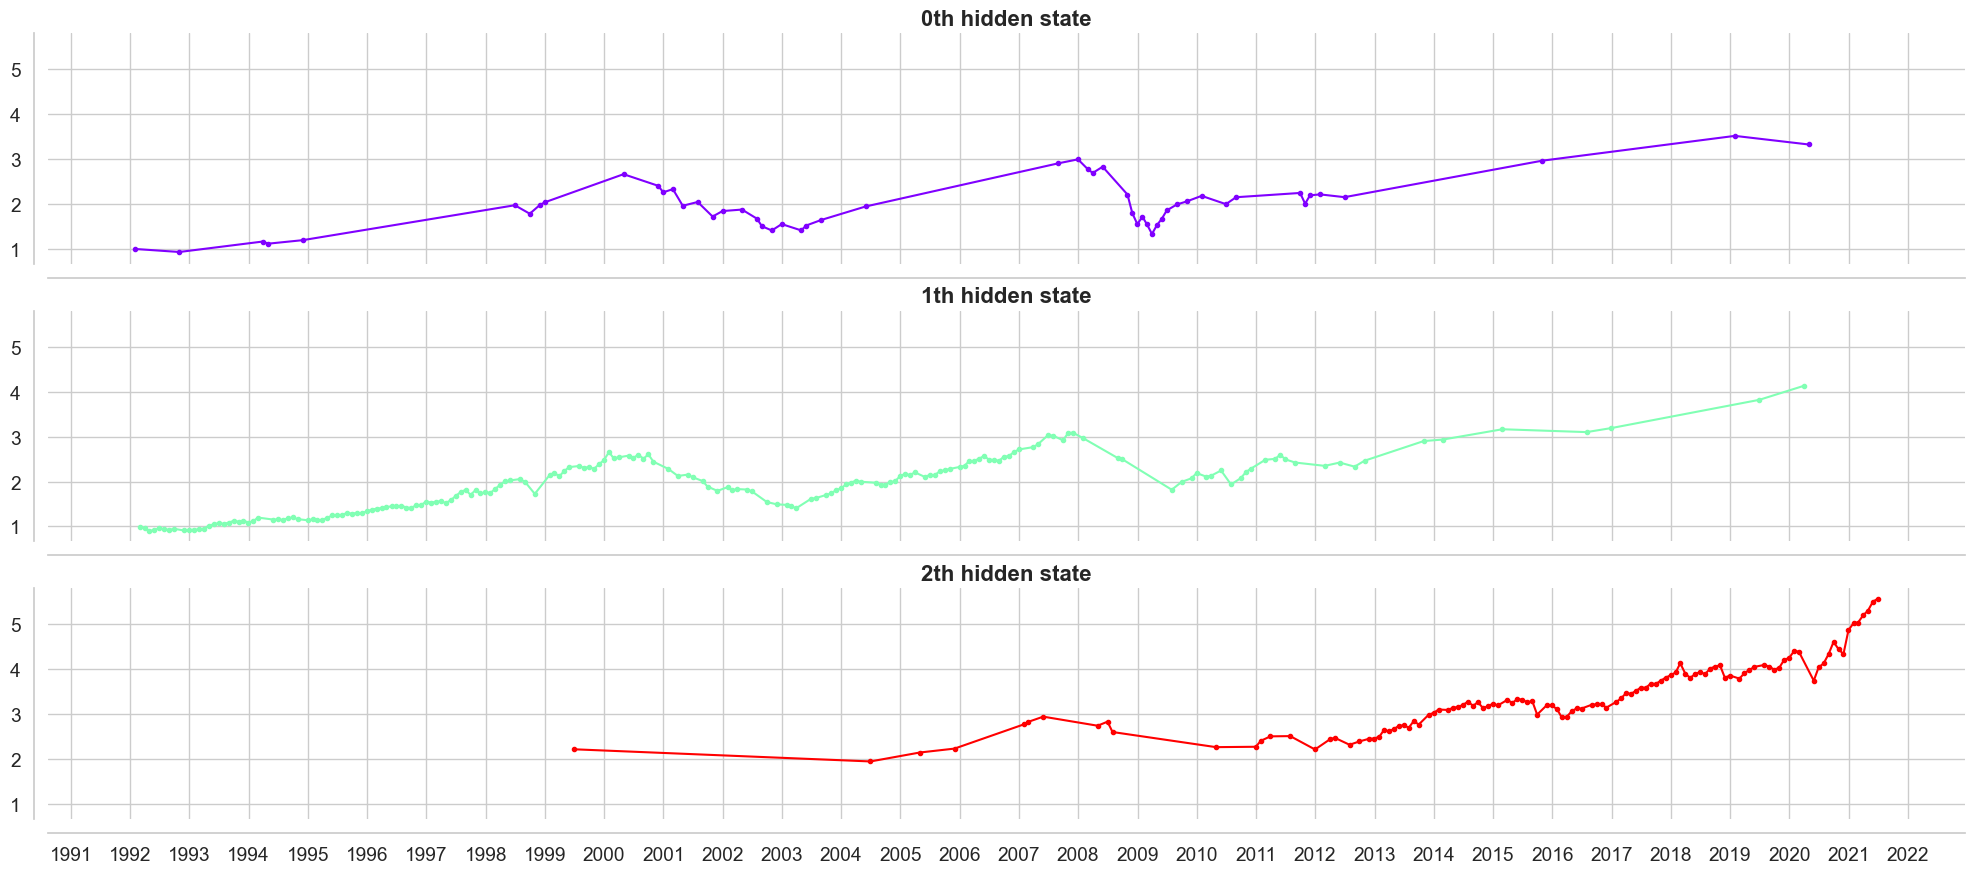

In [9]:
model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=8).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'legend.frameon': True}
sns.set_style('whitegrid', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(20,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[target].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)
    # sns.despine(left=True, bottom=True)

plt.tight_layout()
fig.savefig(os.path.join(strategy_dir,'Hidden Markov (Mixture) Model_Regime Subplots.png'))

        Date  states  msci_world  msci_emerging  bb_world_agg  bb_corp_hy  \
0 1992-01-31       0    0.000000       0.000000     -0.002171    0.035225   
1 1992-02-29       1   -0.020678       0.103012     -0.013095    0.024673   
2 1992-03-31       1   -0.017357       0.054748      0.003074    0.012399   
3 1992-04-30       1   -0.066034       0.029763      0.003851    0.003798   
4 1992-05-31       1    0.027579      -0.009451      0.006528    0.014110   

   us_short_treasury  msci_world_cum  mkt_cret  
0          -0.000984        1.000000  0.000000  
1           0.003087        0.979322 -0.020678  
2          -0.000196        0.962324 -0.038034  
3           0.009191        0.898778 -0.104068  
4           0.009302        0.923565 -0.076490  


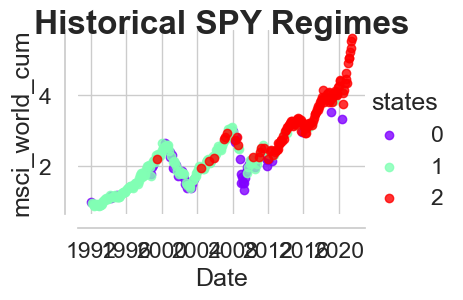

In [12]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.msci_world.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
print(states.head())

sns.set_style('whitegrid', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=1.31)
fg.map(plt.scatter, 'Date', 'msci_world_cum', alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')
fg.savefig(os.path.join(strategy_dir,'Hidden Markov (Mixture) Model_SPY Regimes.png'))